## 使用 Keras 執行 LSTM 模型

- 資料集: https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv

#### 1. 匯入數據

In [1]:
import numpy as np
import pandas as pd
from numpy.fft import fft, fftshift, fftfreq
import scipy.signal as signal
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams["axes.unicode_minus"] = False
import datetime

sunspots = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv")

display(sunspots.head())

display(sunspots.shape)

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


(2820, 2)

#### 2. 顯示數據隨時間的變化

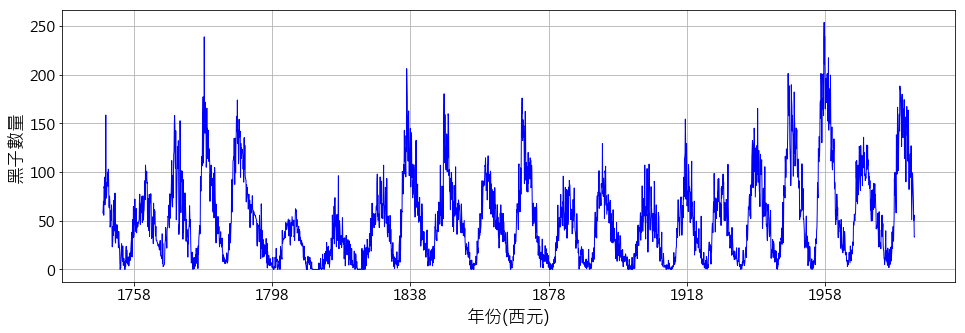

In [2]:
month = np.array(sunspots["Month"])
date_time = pd.to_datetime(month)

num = np.array(sunspots["Sunspots"])

fig, axes = plt.subplots(figsize=(16, 5))
axes.plot(date_time, num, lw = 1, color = "blue")
axes.set_xlabel("年份(西元)", fontsize = 18)
axes.set_ylabel("黑子數量", fontsize = 18)
axes.tick_params(axis = 'both', labelsize = 15)
plt.grid()
plt.show()

#### 3. 將數據做頻譜分析

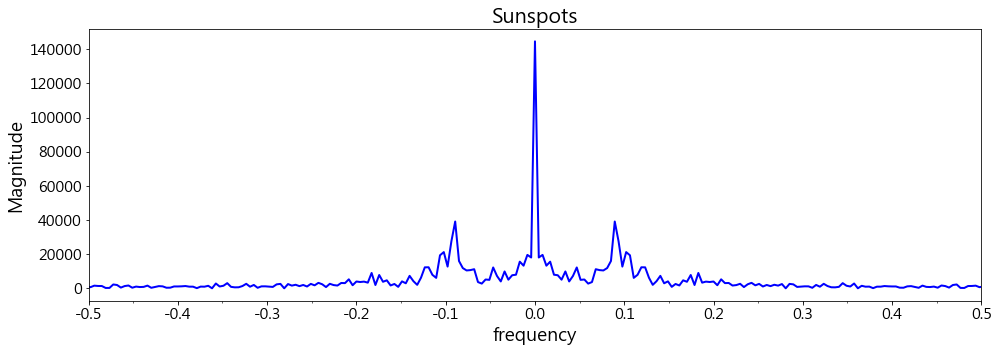

In [3]:
N = 2820  # number of samples
fs = 12   # (1/year)

f = fftshift(fftfreq(N, 1/fs))

Num = fftshift(fft(num))
Num_m = abs(Num)
    
fig, axes = plt.subplots(figsize=(16, 5))
axes.plot(f, Num_m, lw = 2, color = "blue")
axes.set_xlabel("frequency", fontsize = 18)
axes.set_ylabel("Magnitude", fontsize = 18)
axes.set_title("Sunspots", fontsize = 20)
axes.tick_params(axis = 'both', labelsize = 15)
axes.set_xlim(-0.5, 0.5)
axes.xaxis.set_major_locator(mpl.ticker.MaxNLocator(10))
axes.xaxis.set_minor_locator(mpl.ticker.MaxNLocator(20))
plt.show()

#### 4. 顯示數據的自相關(autocorrelation)

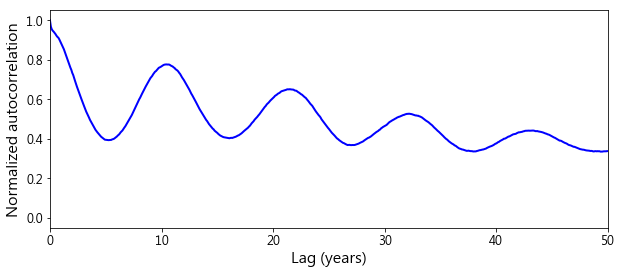

In [4]:
def autocorr(x):
    R = np.correlate(x, x, "full")
    
    return R[int(R.size/2):]

auto_corr = autocorr(num)
normalized_autocorr = auto_corr / np.max(auto_corr)

fig, axes = plt.subplots(figsize=(10, 4))
axes.plot(np.arange(num.size)/12, normalized_autocorr, lw = 2, color = "Blue")
axes.set_xlabel("Lag (years)", fontsize = 15)
axes.set_ylabel("Normalized autocorrelation", fontsize = 15)
axes.set_xlim(0, 50)
axes.tick_params(axis = 'both', labelsize = 12)
plt.show()

#### 5. 數據預處理 (1): 將數據範圍限制在 0 ~ 1 之間

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Feature Scaling
'''
scaled_dataset = (num - np.min(num)) / (np.max(num) - np.min(num))
scaled_dataset
'''
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(sunspots[["Sunspots"]])
scaled_dataset

array([[0.2285264 ],
       [0.24665091],
       [0.27580772],
       ...,
       [0.21985816],
       [0.13120567],
       [0.13159968]])

#### 6. 數據預處理 (2): 將數據分成訓練和測試資料

In [6]:
# 4/5 資料為訓練資料， 1/5 資料為測試資料
train_size = int(len(scaled_dataset) * 0.8)
test_size = len(scaled_dataset) - train_size

train, test = scaled_dataset[0:train_size, :], scaled_dataset[train_size:len(scaled_dataset), :]

print("train[:5, :]=")
display(train[:5, :])
print("-----------------------")
print("test[:5, :]=")
display(test[:5, :])

train[:5, :]=


array([[0.2285264 ],
       [0.24665091],
       [0.27580772],
       [0.21946414],
       [0.33490938]])

-----------------------
test[:5, :]=


array([[0.52206462],
       [0.50630418],
       [0.33057526],
       [0.43065406],
       [0.45981087]])

#### 7. 數據預處理 (3): 將訓練資料分成兩批並更改其形狀，一份用來執行訓練、另一份與訓練的結果作比較並計算 loss

In [7]:
# 產生 (x, y) 資料集，y 是 x 間隔 1 個月後的黑子數量
def train_windows(dataset, look_back, interval):
    data_x, data_y = [], []
    
    for i in range(len(dataset)-look_back-interval):
        data_x.append(dataset[i:(i+look_back), 0])
        data_y.append(dataset[i+look_back+interval, 0])
    
    return np.array(data_x), np.array(data_y)

look_back = 1
time_shift = 0

train_x, train_y = train_windows(train, look_back, time_shift)
test_x, test_y = train_windows(test, look_back, time_shift)

# Reshape input to be (number of samples, time steps, number of features)
time_steps = 1
train_X = np.reshape(train_x, (int(train_x.shape[0]/time_steps), time_steps, train_x.shape[1]))
test_X = np.reshape(test_x, (int(test_x.shape[0]/time_steps), time_steps, test_x.shape[1]))

train_Y = np.reshape(train_y, (int(train_y.shape[0]/time_steps), time_steps))

print("train_x.shape = ", train_x.shape)
print("train_y.shape = ", train_y.shape)
print("test_x.shape = ", test_x.shape)
print("test_y.shape = ", test_y.shape)
print("-------------------------------")
print("train_X.shape = ", train_X.shape)
print("test_X.shape = ", test_X.shape)
print("-------------------------------")
print("train_Y.shape = ", train_Y.shape)

train_x.shape =  (2255, 1)
train_y.shape =  (2255,)
test_x.shape =  (563, 1)
test_y.shape =  (563,)
-------------------------------
train_X.shape =  (2255, 1, 1)
test_X.shape =  (563, 1, 1)
-------------------------------
train_Y.shape =  (2255, 1)


#### 8. 建立 LSTM 模型

In [8]:
# 匯入所需的模組
from keras.models import Sequential
from keras.layers import Dense, LSTM

hidden_dim = 10
output_dim = 1

# 建立線性堆疊模型(骨架)
model = Sequential()

# 建立輸入層與 LSTM 層 - 1
# 使用 return_sequences = True，讓輸出的形狀為 (batch sizes, time steps, number of features)
model.add(LSTM(units = hidden_dim, input_shape = (time_steps, 1), return_sequences = True,
               name = "LSTM-1"))

# 建立 LSTM 層 - 2     
model.add(LSTM(units = hidden_dim, name = "LSTM-2"))

# 建立輸出層
model.add(Dense(units = output_dim, name = "Output_layer"))

# 查看模型摘要
print(model.summary())

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM-1 (LSTM)                (None, 1, 10)             480       
_________________________________________________________________
LSTM-2 (LSTM)                (None, 10)                840       
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
None


#### 9. 執行訓練

In [9]:
# 定義訓練方式
# 參數說明: loss (損失函數)，optimizer (最佳化的方法)
model.compile(loss = 'mean_absolute_error', optimizer = 'adam')

train_history = model.fit(train_X, train_Y, epochs = 50, batch_size = 100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
2255/2255 [==============================] - 1s 589us/step - loss: 0.1544
Epoch 2/50
2255/2255 [==============================] - 0s 39us/step - loss: 0.1251
Epoch 3/50
2255/2255 [==============================] - 0s 39us/step - loss: 0.1096
Epoch 4/50
2255/2255 [==============================] - 0s 39us/step - loss: 0.1045
Epoch 5/50
2255/2255 [==============================] - 0s 40us/step - loss: 0.1008
Epoch 6/50
2255/2255 [==============================] - 0s 40us/step - loss: 0.0955
Epoch 7/50
2255/2255 [==============================] - 0s 39us/step - loss: 0.0883
Epoch 8/50
2255/2255 [==============================] - 0s 40us/step - loss: 0.0783
Epoch 9/50
2255/2255 [==============================] - 0s 41us/step - loss: 0.0654
Epoch 10/50
2255/2255 [==============================] - 0s 40us/step - loss: 0.0529
Epoch 11/50
2255/2255 [==============================] - 0s 46us/step - loss: 0.0469
Epoch 12/50
2255/2255 [==

#### 10. 檢視訓練過程中 loss function 的變化

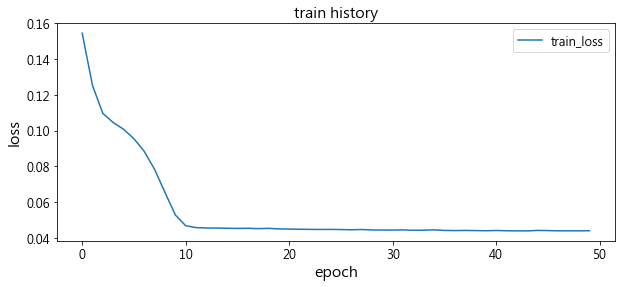

In [10]:
def show_train_history(train_history, train):
    fig, ax = plt.subplots(figsize = (10, 4))
    plt.plot(train_history.history[train])
    plt.title('train history', fontsize = 15)
    plt.xlabel('epoch', fontsize = 15)
    plt.ylabel(train, fontsize = 15)
    ax.tick_params(axis = 'both', labelsize = 12)
    plt.legend(['train_loss'], fontsize = 12)
    plt.show()
    
# loss function 的變化    
show_train_history(train_history, 'loss')

#### 11. 將預測的數據轉回成原來資料的規模

In [11]:
# 執行預測
train_Predict = model.predict(train_X)
test_Predict = model.predict(test_X)

# 回復預測資料值為原始數據的規模
train_Pre_o = scaler.inverse_transform(train_Predict)
test_Pre_o = scaler.inverse_transform(test_Predict)

print("train_Pre_o[:5, :] = ")
display(train_Pre_o[:5, :])
print("-----------------------------------------------------------------")
print("test_Pre_o[:5, :] = ")
display(test_Pre_o[:5, :])

train_Pre_o[:5, :] = 


array([[58.17252],
       [62.57073],
       [69.62348],
       [55.97013],
       [83.80522]], dtype=float32)

-----------------------------------------------------------------
test_Pre_o[:5, :] = 


array([[127.11183],
       [123.58433],
       [ 82.77144],
       [106.32206],
       [113.03709]], dtype=float32)

#### 12. 將預測的數據放置到原始數據的時間軸上

In [12]:
#train_Pre_O = np.reshape(train_Pre_o, (train_Pre_o.shape[0] * train_Pre_o.shape[1], 1))
#test_Pre_O = np.reshape(test_Pre_o, (test_Pre_o.shape[0] * test_Pre_o.shape[1], 1))

trainPredictPlot = np.zeros(scaled_dataset.size)
testPredictPlot = np.zeros(scaled_dataset.size)

#trainPredictPlot[ 1: train_x.size + 1] = train_Pre_o[:, 0]
#testPredictPlot[train.size + 1 : ] = test_Pre_o[:, 0]

trainPredictPlot[ : train_x.size] = train_Pre_o[:, 0]
testPredictPlot[train.size : -1] = test_Pre_o[:, 0]

#### 13. 查看原始數據和預測的訓練、測試資料趨勢圖

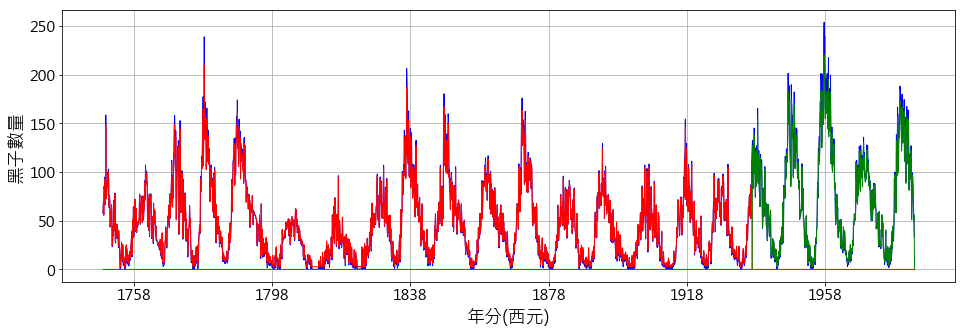

In [13]:
fig, axes = plt.subplots(figsize=(16, 5))
axes.plot(date_time, num, lw = 1, color = "blue")
axes.plot(date_time, trainPredictPlot, lw = 1, color = "red")
axes.plot(date_time, testPredictPlot, lw = 1, color = "green")
axes.set_xlabel("年分(西元)", fontsize = 18)
axes.set_ylabel("黑子數量", fontsize = 18)
axes.tick_params(axis = 'both', labelsize = 15)
axes.set_xlim()
plt.grid()
plt.show()

#### 14. 查看預測的訓練資料趨勢圖 (短時間)

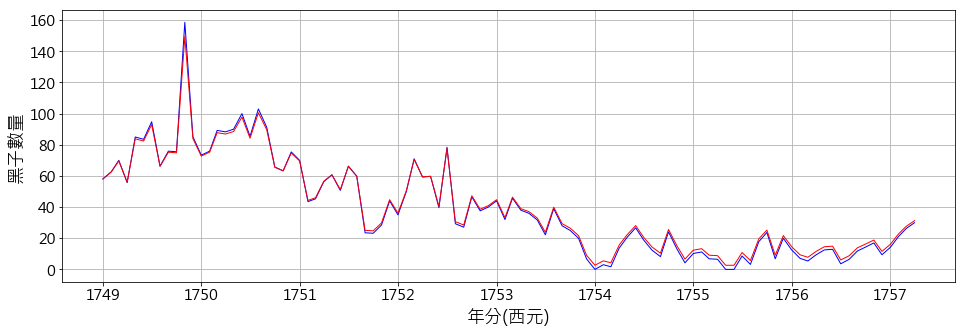

In [14]:
fig, axes = plt.subplots(figsize=(16, 5))
axes.plot(date_time[:100], num[:100], lw = 1, color = "blue")
axes.plot(date_time[:100], trainPredictPlot[:100], lw = 1, color = "red")
axes.set_xlabel("年分(西元)", fontsize = 18)
axes.set_ylabel("黑子數量", fontsize = 18)
axes.tick_params(axis = 'both', labelsize = 15)
axes.set_xlim()
plt.grid()
plt.show()

#### 15. 查看預測的測試資料趨勢圖 (短時間)

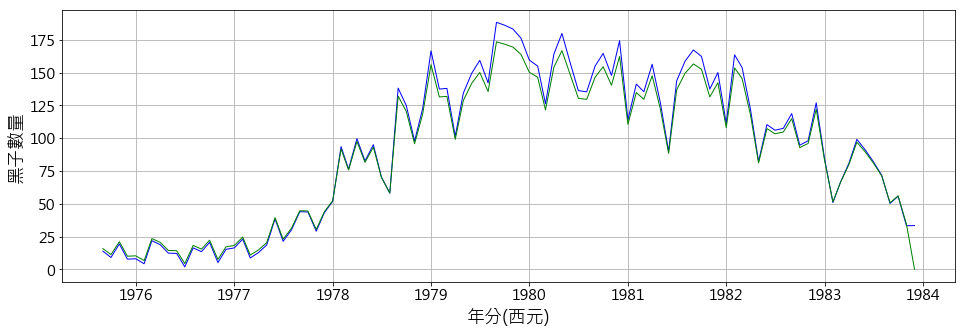

In [15]:
fig, axes = plt.subplots(figsize=(16, 5))
axes.plot(date_time[-100:], num[-100:], lw = 1, color = "blue")
axes.plot(date_time[-100:], testPredictPlot[-100:], lw = 1, color = "green")
axes.set_xlabel("年分(西元)", fontsize = 18)
axes.set_ylabel("黑子數量", fontsize = 18)
axes.tick_params(axis = 'both', labelsize = 15)
axes.set_xlim()
plt.grid()
plt.show()

**Some references about LSTM layer of Keras:**

- [What is "units" in LSTM layer of Keras?](https://zhuanlan.zhihu.com/p/58854907)


- [6 種用 LSTM 做時間序列預測的模型結構-Keras實現](https://zhuanlan.zhihu.com/p/59862381)


- [理解 LSTM 在 keras API 中參數 return_sequences 和 return_state](https://blog.csdn.net/u011327333/article/details/78501054)


- [Understand the Difference Between Return Sequences and Return States for LSTMs in Keras](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/)


- [Stacked Long Short-Term Memory Networks](https://machinelearningmastery.com/stacked-long-short-term-memory-networks/)